In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import math
import cv2
import matplotlib.pyplot as plt
import laserbeamsize as lbs
import mayavi.mlab as mlab
from pint import UnitRegistry
ureg = UnitRegistry()

from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import LogNorm

In [2]:
import math
incoming_beam_radius_mm=np.array(( 0.04, 0.125, 0.14,0.20,0.25,0.3,1.1,2,3,4))#np.linspace(0.04, 4, 10)# #mm
L_mm = np.linspace(1, 600, 10)#np.array((20, 50, 100, 120, 150, 200, 220, 250, 300, 320, 350, 400, 420))
wavel_mm = 1030/(10**6)
m2 =1.2
pulse_energy_J = 10**-6 #joule
ref_index = 1.45
a_angle_deg = 1 #degrees

'''Axicon Calculations'''

def axicon(incoming_beam_radius_mm, L_mm, wavel_mm, m2, pulse_energy_J, ref_index, a_angle_deg):
    lenj = len(incoming_beam_radius_mm)
    dof = np.zeros(lenj)
    index = np.zeros(lenj*len(L_mm)) #0comes from bb, 1 from ring
    diameter = np.zeros(lenj*len(L_mm))
    fluence = np.zeros(lenj*len(L_mm))
    AI_Z = np.zeros(lenj*len(L_mm))
    I_in_mW__mm = np.zeros(lenj)
    for j in range(lenj):
        dof[j] =  incoming_beam_radius_mm[j]/((ref_index-1)*math.radians(a_angle_deg))
        I_in_mW__mm[j] = 50/(np.pi*incoming_beam_radius_mm[j])
        for i in range(len(L_mm)):
            if  dof[j] >= L_mm[i]:
                index[i+lenj*j] = 0
                #L_mm_bessel = L_mm[i]
                kappa = 2.405
                z_bb = L_mm[i]
                beta_angle_rad = abs(math.radians(a_angle_deg)-math.asin(ref_index*math.asin(math.radians(a_angle_deg))))
                central_lobe_diameter_mm = 2*kappa/ ((2*np.pi/wavel_mm)*np.sin(beta_angle_rad))
                diameter[i+lenj*j]= central_lobe_diameter_mm
                #print("bb diameter is constant for bb, and equals",diameter[i+10*j])
                central_lobe_fluence_J_cm2 = (4*pulse_energy_J)/((central_lobe_diameter_mm/2)*z_bb*np.tan(beta_angle_rad))
                fluence[i+lenj*j] = central_lobe_fluence_J_cm2 #CHANGE 10 to len(inp)
                M = (2*np.pi*((ref_index -1)**2)*((math.radians(a_angle_deg))**2))
                AI_Z[i+lenj*j] = M*I_in_mW__mm[j]*(z_bb*(ref_index -1)*math.radians(a_angle_deg))*z_bb
            elif dof[j] < L_mm[i] :
                index[i+lenj*j] = 1
                L_mm_ring = L_mm[i]
                ring_thickness_mm = incoming_beam_radius_mm[j]
                ring_diameter_mm = 2*L_mm_ring*np.tan((ref_index-1)*math.radians(a_angle_deg))
                diameter[i+lenj*j]= ring_diameter_mm
                ring_radius_mm = ring_diameter_mm/2
                ring_fluence_J_cm2 = pulse_energy_J/(np.pi*((ring_radius_mm**2-(ring_radius_mm-ring_thickness_mm))**2))
                fluence[i+lenj*j] = ring_fluence_J_cm2
            else:
                print("error")
    return incoming_beam_radius_mm, dof,  diameter, fluence, index, AI_Z

            
a = axicon(incoming_beam_radius_mm, L_mm, wavel_mm, m2, pulse_energy_J, ref_index, a_angle_deg)
print(len(a[0]), len(a[1]), len(a[2]), len(a[3]), len(a[4]), len(a[5]))

10 10 100 100 100 100


In [3]:
InputBeamRadius_mm=np.repeat(a[0], len(L_mm))
DOF_mm=np.repeat(a[1], len(L_mm))
Distance_Z_mm=np.tile(L_mm, len(incoming_beam_radius_mm))
Diameter = a[2]
Fluence = a[3]
Index = a[4]
AIZ = a[5]

C:\Users\Giorgos\AppData\Local\Temp/ipykernel_41308/1327472134.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u, df2["label_num"] = np.unique(df2["Index"], return_inverse=True)


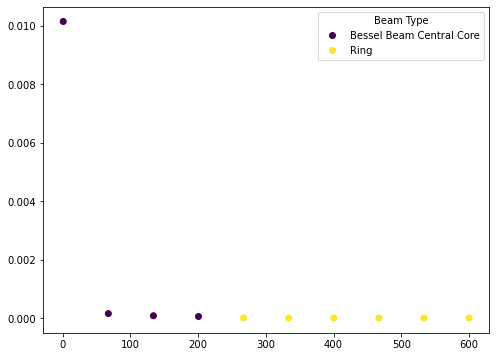

array([0., 1.])

In [16]:
data = {'InputBeam_R': InputBeamRadius_mm,
       'DOF': DOF_mm,
       'L':Distance_Z_mm,
       'Diameter': Diameter,
       'Fluence': Fluence,
       'Index': Index,
       'Axial_I': AIZ}

df = pd.DataFrame(data)
# print(df)
# print(type(df))
# print(df.head(10))
#df2 = df.groupby(by=["Index"])
# plt.scatter(df['L'].iloc[1:10], df['Fluence'].iloc[1:10], cmap = df['Index'].iloc[1:10])
#df.plot.scatter(x="L", y="Fluence", c="DOF", cmap="viridis", s=50);
# groups = df.groupby('Index')

# for name, group in groups:
#     plt.plot(group.L.iloc[1:50], group.Fluence.iloc[1:50], marker='o', linestyle='', markersize=5, label=name)

# plt.legend( ['Bessel Beam Central Core', 'Ring']);

# plt.show()


# Fluence, Length = df['Fluence'].iloc[1:10],df['L'].iloc[1:10]
# beam_type, DOF = df['Index'].iloc[1:10], df['DOF'].iloc[1:10]

# plt.scatter(Length, Fluence, label=None,
#             c=DOF, cmap='viridis',
#             s=beam_type, linewidth=5, alpha=0.8)
# #plt.axis(aspect='equal')
# plt.xlabel('Length')
# plt.ylabel('Fluence')
# plt.colorbar(label='DOF')
# #plt.clim(3, 5)

# for beam_type in [0, 1]:
#     plt.scatter([], [], c='k', alpha=0.8, s=beam_type,
#                 label=str(beam_type))
# plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='DOF')
# plt.legend( ['Bessel Beam Central Core', 'Ring'])
# plt.title('Axicon Lens Beam Calculations');

# groups = df.iloc[60:70].groupby('Index')
# for name, group in groups:
#     plt.plot(group.L.iloc[60:70], group.Fluence.iloc[60:70], marker='o', linestyle='', markersize=5, label=name)
    
# plt.legend( ['Bessel Beam Central Core', 'Ring']);
df2= df.iloc[70:80]
# plt.scatter(df['L'].iloc[60:70], df['Fluence'].iloc[60:70], c=df['Index'].iloc[60:70], cmap='viridis')
# u, df["label_num"] = np.unique(df["label"], return_inverse=True)
fig, ax = plt.subplots(figsize=(8,6))

u, df2["label_num"] = np.unique(df2["Index"], return_inverse=True)

sc = ax.scatter(x = "L", y = "Fluence", c = "Index", data=df2)
ax.legend(sc.legend_elements()[0], ['Bessel Beam Central Core', 'Ring'], title="Beam Type")
# ax.legend( ['Bessel Beam Central Core', 'Ring'])

plt.show()
u


In [5]:
# import pandas as pd
# import matplotlib.pylab as plt
# import numpy as np

# # random df
# df = pd.DataFrame(np.random.randint(0,10,size=(5, 2)), columns=['x','y'])
# df['label'] = ['yes','no','yes','yes','no']
# print(df)
# # plot groupby results on the same canvas 
# fig, ax = plt.subplots(figsize=(8,6))

# u, df["label_num"] = np.unique(df["label"], return_inverse=True)

# sc = ax.scatter(x = "x", y = "y", c = "label_num", data=df)
# ax.legend(sc.legend_elements()[0], u, title="Label")

# plt.show()

In [6]:
import math
incoming_beam_radius_mm=1#np.linspace(0.04, 4, 10)#np.array(( 0.05, 0.125, 0.14,0.20,0.25,0.3,1,3,4,5,6,7,8)) #mm
L_mm = np.linspace(1, 130, 50)#np.array((20, 50, 100, 120, 150, 200, 220, 250, 300, 320, 350, 400, 420))
wavel_mm = 1030/(10**6)
m2 =1.2
pulse_energy_J = 10**-6 #joule
ref_index = 1.45
a_angle_deg = 1 #degrees
rep_rate = 1000 #Hz
t_pulse = 400*10**-15 #s



    
def bessel_beam(incoming_beam_radius_mm, L_mm, wavel_mm, m2, pulse_energy_J, ref_index, a_angle_deg, rep_rate, t_pulse):
    peak_power = pulse_energy_J/t_pulse #Watt
    print(peak_power)
    avg_power = pulse_energy_J*rep_rate #Watt
    print(avg_power)
    dof =  incoming_beam_radius_mm/((ref_index-1)*math.radians(a_angle_deg))
    I_in_W__mm = avg_power/(np.pi*(incoming_beam_radius_mm*10**-3)**2)
    print(I_in_W__mm)
    
    kappa = 2.405
    beta_angle_rad = abs(math.radians(a_angle_deg)-math.asin(ref_index*math.asin(math.radians(a_angle_deg))))
    central_lobe_diameter_mm = 2*kappa/ ((2*np.pi/wavel_mm)*np.sin(beta_angle_rad))
    bb_fluence = np.zeros(len(L_mm))
    AI_Z = np.zeros(len(L_mm))
    for i in range(len(L_mm)):
        if  dof > L_mm[i]:
            z_bb = L_mm[i]
            central_lobe_fluence_J_cm2 = (4*pulse_energy_J)/((central_lobe_diameter_mm/2)*z_bb*np.tan(math.radians(beta_angle_rad)))
            bb_fluence[i] = central_lobe_fluence_J_cm2
            M = (2*np.pi*((ref_index -1)**2)*((math.radians(a_angle_deg))**2))
            AI_Z[i] = M*I_in_W__mm*(z_bb*10**-3)*np.exp(-(((z_bb*10**-3)**2)*((ref_index -1)**2)*(math.radians(a_angle_deg))**2)/((incoming_beam_radius_mm*10**-3)**2))
    return dof,  I_in_W__mm, central_lobe_diameter_mm, bb_fluence, AI_Z
    
    


In [7]:
inputbeamr = np.linspace(0.04, 4, 10)
def inputbeam(beamradius):
    DOF = np.zeros(len(beamradius))
    I = np.zeros(len(beamradius))
    central_lobe_diam = np.zeros(len(beamradius))
    for k in range(len(beamradius)):
        a = bessel_beam(beamradius, L_mm, wavel_mm, m2, pulse_energy_J, ref_index, a_angle_deg, rep_rate, t_pulse)
        print(a)
        DOF[k] = a[0]
        I[k] = a[1] 
        central_lobe_diam[k] = a[2]
    return DOF, I, central_lobe_diam
        
    
inputbeam(inputbeamr)

2500000.0
0.001
[1.98943679e+05 1.38155333e+03 3.76075007e+02 1.72096608e+02
 9.82437920e+01 6.34386731e+01 4.43180394e+01 3.26994870e+01
 2.51159802e+01 1.98943679e+01]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
b =bessel_beam(incoming_beam_radius_mm, L_mm, wavel_mm, m2, pulse_energy_J, ref_index, a_angle_deg, rep_rate, t_pulse)
print(type(b))

In [ ]:
plt.scatter(L_mm, b[3])


In [ ]:
# #fig1, [[ax1, ax3], [ax5, ax7]] = plt.subplots(2,2, figsize=(15, 7))
fig2, (ax1, ax3) = plt.subplots(2,1, figsize=(12, 7))

color = 'tab:red'
ax1.set_xlabel('Input Beam Radius (mm)')
ax1.set_ylabel('Depth of Focus (mm)', color=color)
ax1.set_title('Axicon Lens Parameters', fontsize=18)
ax1.plot(L_mm, b[3], label='Depth of Focus (DOF)', color=color)
#ax1.set_ylim(0, 1200)

ax1.grid()
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(direction='out', length=8, width=2, colors='black',
               grid_color='black', grid_alpha=0.2)
ax1.tick_params(which='minor', length=6)
ax1.tick_params(axis='y', labelcolor=color)

#ax2 = np.array([a.twinx() for a in ax1.ravel()]).reshape(1,2)
#x3.append(ax1.twinx())
ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Fluence (J/' + r'$cm^{2})$', color=color)  # we already handled the x-label with ax1
ax2.plot(L_mm, b[4], label='Ring Fluence', color=color)

ax2.grid()
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(direction='out', length=8, width=2, colors='black',
               grid_color='black', grid_alpha=0.2)
ax2.tick_params(which='minor', length=6)
ax2.tick_params(axis='y', labelcolor=color)


color = 'tab:green'
ax3.set_xlabel('Distance from axicon to image/focused spot (mm)')
ax3.set_ylabel('Ring Diameter (mm)', color=color)
ax3.plot(L_mm, b[3],  label='Diameter of the generated ring shaped spot', color=color)

ax3.grid()
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(direction='out', length=8, width=2, colors='black',
               grid_color='black', grid_alpha=0.2)
ax3.tick_params(which='minor', length=6)
ax3.tick_params(axis='y', labelcolor=color)

#ax2 = np.array([a.twinx() for a in ax1.ravel()]).reshape(1,2)
#x3.append(ax1.twinx())
#ax3.set_ylim(0, 10)
ax4 = ax3.twinx() # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax4.set_ylabel('Fluence (J/' + r'$cm^{2})$', color=color)  # we already handled the x-label with ax1
ax4.plot(L_mm, b[4], label='Ring Fluence',color=color)

ax4.grid()
ax4.xaxis.set_minor_locator(AutoMinorLocator())
ax4.yaxis.set_minor_locator(AutoMinorLocator())
ax4.tick_params(direction='out', length=8, width=2, colors='black',
               grid_color='black', grid_alpha=0.2)
ax4.tick_params(which='minor', length=6)
ax4.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper center', bbox_to_anchor=(0.24, 0.98))
ax2.legend(loc='upper center', bbox_to_anchor=(0.2, 0.8))
ax3.legend(loc='upper center', bbox_to_anchor=(0.35, 0.98))
ax4.legend(loc='upper center', bbox_to_anchor=(0.2, 0.8))
fig2.tight_layout()  # otherwise the right y-label is slightly clipped
#fig2.savefig('axicon_calc.png')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# make dataframe
df = pd.DataFrame(np.random.normal(size=(200,2)), columns=['A', 'B'])
print(df)
# plot melted dataframe in a single command
sns.histplot(df.melt(), x='value', hue='variable',
             multiple='dodge', shrink=.75, bins=20);

In [ ]:
#creating sample data 
sample_data={'col_name_1':np.random.rand(20),
      'col_name_2': np.random.rand(20),'col_name_3': np.arange(20)*100}
df= pd.DataFrame(sample_data)
sns.histplot(x="col_name_1",data=df, hue="col_name_3")